**写在前面**本节内容是 [Datawhale五月组队学习 - 集成学习（下）- CH6-集成学习之案例分享 -【Task14 集成学习案例一（幸福感预测）】](https://github.com/datawhalechina/team-learning-data-mining/tree/master/EnsembleLearning) 的学习笔记，学习周期5天：  
学习赛地址为：[快来一起挖掘幸福感！](https://tianchi.aliyun.com/competition/entrance/231702/introduction)

## 库和数据

In [291]:
import numpy as np
import pandas as pd
import re
from tqdm.notebook import tqdm
import sys 
sys.path.append('D:/Python/Python Codes/tools') 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import  KFold, StratifiedKFold,GroupKFold, RepeatedKFold

PATH = './data/案例一/'

In [259]:
# # 查看编码格式
# from chardet import detect
# f = open(PATH+'train.csv','rb')
# data = f.read()
# print(detect(data))
# 读取文件并减小内存消耗
from Data import reduce_mem_usage
train = reduce_mem_usage(pd.read_csv(PATH+'train.csv', encoding='GB2312'))
test = reduce_mem_usage(pd.read_csv(PATH+'test.csv', encoding='GB2312'))
target = train['happiness']
del train['happiness']

Memory usage of dataframe is 8960128.00 B


  0%|          | 0/140 [00:00<?, ?it/s]

Memory usage after optimization is: 1845536.00 B
Decreased by 79.4%
Memory usage of dataframe is 3300544.00 B


  0%|          | 0/139 [00:00<?, ?it/s]

Memory usage after optimization is: 640640.00 B
Decreased by 80.6%


## 预处理

In [262]:
# 时间:由于是调查时间，没必要细致分析，简单拆分
train['survey_time'] = train['survey_time'].map(pd.to_datetime)
train['year'] = train['survey_time'].dt.year
train['month'] = train['survey_time'].dt.month
train['day'] = train['survey_time'].dt.day
train['hour'] = train['survey_time'].dt.hour
train['minute'] = train['survey_time'].dt.minute
train['second'] = train['survey_time'].dt.second
del train['survey_time']
test['survey_time'] = test['survey_time'].map(pd.to_datetime)
test['year'] = test['survey_time'].dt.year
test['month'] = test['survey_time'].dt.month
test['day'] = test['survey_time'].dt.day
test['hour'] = test['survey_time'].dt.hour
test['minute'] = test['survey_time'].dt.minute
test['second'] = test['survey_time'].dt.second
del test['survey_time']

# 字符串：感觉处理的意义不大，而且时间有限，不进行处理
str_list = ['edu_other', 'property_other', 'invest_other']
train.loc[:,'edu_other'][train.loc[:,'edu_other'].notna()] # 1:(‘夜校’，3)
train.loc[:,'property_other'][train.loc[:,'property_other'].notna()] # 52
train.loc[:,'invest_other'][train.loc[:,'invest_other'].notna()] # 24
train.drop(str_list, axis=1, inplace=True)
test.drop(str_list, axis=1, inplace=True)

# 方差筛选
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold(threshold=0) # 默认为0,即完全相同
vt.fit(train)
mask = vt.get_support() 
train = train.loc[:,mask]
test = test.loc[:,mask]

0it [00:00, ?it/s]

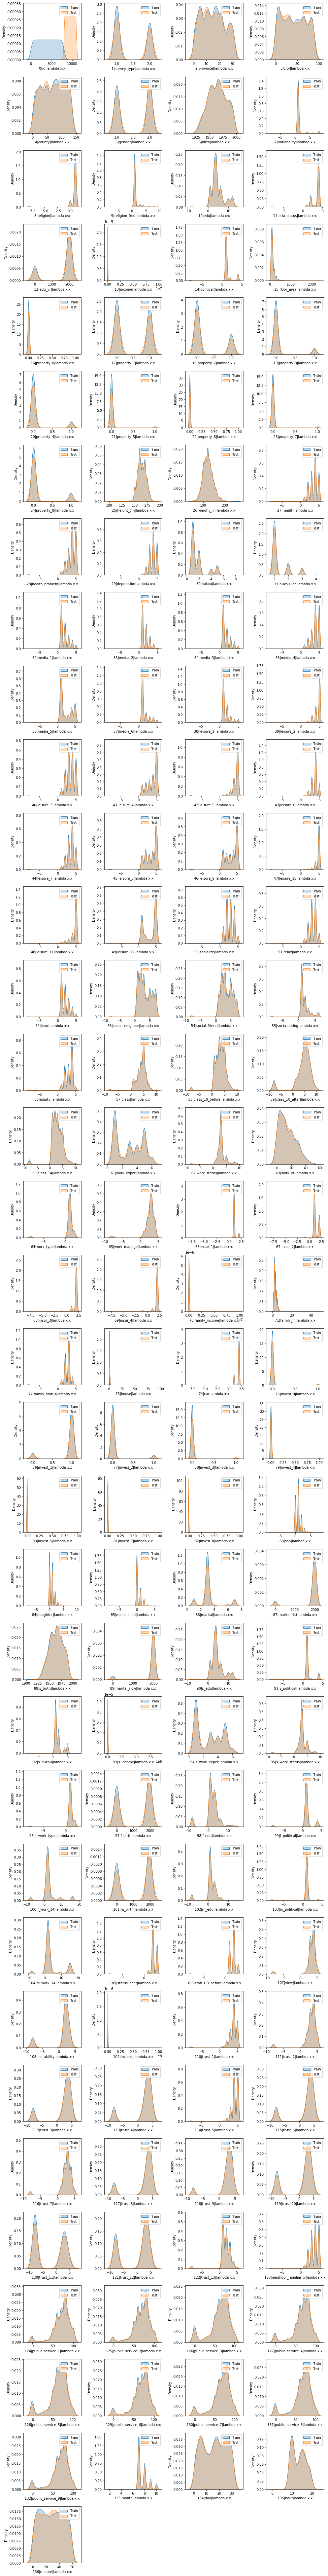

In [90]:
# 数据分布：基本吻合，不做处理
from EDA import TrainVsTest
TrainVsTest(train, test)

In [263]:
# 记录有序类别特征和无序类别特征：写在index里了，直接读入
index = pd.read_excel(PATH+'index.xlsx')
index_map = index[['变量名','问题']]
map_dict = index_map.iloc[2:,:].to_dict()
map_dict = dict(zip(map_dict['变量名'].values(), map_dict['问题'].values())) # 字典映射
unordered = index[index['类型']==0][['变量名','问题']] # 无序类别特征
ordered = index[index['类型']==1][['变量名','问题']] # 有序类别特征
numerical = index[index['类型']==2][['变量名','问题']] # 数值特征

## 特征工程

### 缺失值

In [264]:
# 缺失值处理
## 80%以上删去
keepcol = train.dropna(axis=1, thresh=train.shape[0]*0.2).columns 
train = train.loc[:, keepcol]
test = test.loc[:, keepcol]

In [231]:
# 查看存在缺失值的特征
isna_col = train.loc[: ,train.isna().sum()!=0].columns
list(zip(isna_col, isna_col.map(map_dict)))

[('edu_status', '您目前的最高教育程度的状态 '),
 ('edu_yr', '您已经完成的最高学历是哪一年获得的“已完成”指已获得毕业证'),
 ('hukou_loc', '您目前的户口登记地'),
 ('social_neighbor', '您与邻居进行社交娱乐活动的频繁程度'),
 ('social_friend', '您与其他朋友进行社交娱乐活动的频繁程度'),
 ('work_status', '下列各种情形，哪一种更符合您目前工作的状况'),
 ('work_yr', '从您第一份非农工作到目前的工作，您一共工作了多少年'),
 ('work_type', '您目前工作的性质'),
 ('work_manage', '您目前工作的管理活动情况'),
 ('family_income', '您家去年全年家庭总收入'),
 ('minor_child', '您有几个18周岁以下未成年子女'),
 ('marital_1st', '您第一次结婚的时间'),
 ('s_birth', '您目前的配偶或同居伴侣是哪一年出生的'),
 ('marital_now', '您与目前的配偶是哪一年结婚的'),
 ('s_edu', '您配偶或同居伴侣目前的最高教育程度'),
 ('s_political', '您配偶或同居伴侣的政治面貌'),
 ('s_hukou', '您配偶或同居伴侣目前的户口登记状况'),
 ('s_income', '您配偶或同居伴侣去年全年的总收入'),
 ('s_work_exper', '您配偶或同居伴侣的工作经历及状况'),
 ('s_work_status', '下列各种情形，哪一种更符合您配偶或同居伴侣目前的工作状况'),
 ('s_work_type', '您配偶或同居伴侣目前工作的性质')]

In [266]:
# 这里按原数据记为错误的值进行填充
for k,v in train.loc[:, isna_col].min().items():
    if v<=0:
        train[k] = train[k].fillna(v)
        test[k] = test[k].fillna(v)

In [267]:
# 剩下的使用模型填充
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
def fillna_model(X_missing, X_full, method='rf'):
    X_missing_reg = X_missing.copy()
    sortindex = np.argsort(X_missing_reg.isnull().sum(axis=0)).values
    for i in tqdm(sortindex):
        # 构建新特征矩阵和新标签
        df = X_missing_reg
        fillc = df.iloc[:,i]
        df = pd.concat([df.iloc[:,df.columns != i],pd.DataFrame(X_full)],axis=1)
        # 在新特征矩阵中，对含有缺失值的列，进行0的填补
        df_0 =SimpleImputer(
            missing_values=np.nan,
            strategy='constant',
            fill_value=0
        ).fit_transform(df)
        # 找出训练集和测试集
        Ytrain, Ytest = fillc[fillc.notnull()], fillc[fillc.isnull()]
        Xtrain, Xtest = df_0[Ytrain.index,:], df_0[Ytest.index,:]
        # 用模型来填补缺失值
        if method=='rf':
            model = RandomForestRegressor(n_estimators=100)
#         elif method=='knn':
#             model = 
        model.fit(Xtrain, Ytrain)
        Ypredict = model.predict(Xtest)
        # 将填补好的特征返回到原始的特征矩阵中
        X_missing_reg.iloc[X_missing_reg.iloc[:,i].isnull(),i] = Ypredict
    return X_missing_reg
# 训练集
na_col1 = train.loc[: ,train.isna().sum()!=0].columns
na_col2 = train.loc[: ,train.isna().sum()==0].columns
train[na_col1] = fillna_model(train[na_col1], train[na_col2])
train[na_col1] = train[na_col1].astype(int)
# 测试集
na_col1 = test.loc[: ,test.isna().sum()!=0].columns
na_col2 = test.loc[: ,test.isna().sum()==0].columns
test[na_col1] = fillna_model(test[na_col1], test[na_col2])
test[na_col1] = test[na_col1].astype(int)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

## 特征组合

### 人工组合

In [270]:
def rule(x):
    return 0 if (x<=0 or np.isnan(x)) else x
# 训练集
## 时间相关
train['age'] = 2015 - train['birth'] # 年龄
train['learn_year'] = (train['edu_yr'] - train['birth']).apply(rule) # 学龄
# train['join_age'] = train['join_party'] - train['birth'] # 入党年龄:缺失太多被删了
train['mar_year'] = (train['marital_1st'] - train['birth']).apply(rule) # 婚龄
train['s_age'] = (2015 - train['s_birth']).apply(rule) # 伴偶年龄
train['s_mar_year'] = (train['marital_1st'] - train['s_birth']).apply(rule) # 伴偶年龄

## 其他 
train['BMI'] = train['weight_jin']/train['height_cm']**2
train['edu_diff'] = (train['edu'] - train['s_edu']).apply(rule) # 个人教育程度与伴偶之差
train['income_diff'] = (train['income'] - train['s_income']).apply(rule) # 个人工资与伴偶之差
train['inc_exp_diff'] = (train['inc_exp'] - train['income']).apply(rule) # 期望工资与实际之差
all_trust = [x for x in train.columns if x.startswith('trust')]
train['all_trust'] = train.loc[:, all_trust].sum(axis=1) # 总信任度

# 测试集
## 时间相关
test['age'] = 2015 - test['birth'] # 年龄
test['learn_year'] = (test['edu_yr'] - test['birth']).apply(rule) # 学龄
# train['join_age'] = train['join_party'] - train['birth'] # 入党年龄:缺失太多被删了
test['mar_year'] = (test['marital_1st'] - test['birth']).apply(rule) # 婚龄
test['s_age'] = (2015 - test['s_birth']).apply(rule) # 伴偶年龄
test['s_mar_year'] = (test['marital_1st'] - test['s_birth']).apply(rule) # 伴偶年龄

## 其他 
test['BMI'] = test['weight_jin']/test['height_cm']**2
test['edu_diff'] = (test['edu'] - test['s_edu']).apply(rule) # 个人教育程度与伴偶之差
test['income_diff'] = (test['income'] - test['s_income']).apply(rule) # 个人工资与伴偶之差
test['inc_exp_diff'] = (test['inc_exp'] - test['income']).apply(rule) # 期望工资与实际之差
all_trust = [x for x in test.columns if x.startswith('trust')]
test['all_trust'] = test.loc[:, all_trust].sum(axis=1) # 总信任度

### 无序类别数据

### 有序类别数据

### 数值数据

## 模型

### 归一化

In [306]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler().fit(train)
train = pd.DataFrame(std.transform(train))
test = pd.DataFrame(std.transform(test))

### 切分

In [307]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, target, random_state=42)

### 线性模型

In [315]:
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, LogisticRegression
liner = LinearRegression().fit(X_train, y_train)
lasso = LassoCV().fit(X_train, y_train)
ridge = RidgeCV().fit(X_train, y_train)
lr = LogisticRegression().fit(X_train, y_train)

In [316]:
y_pred = liner.predict(X_test)
print('liner: ', mean_squared_error(y_test, y_pred))
y_pred = lasso.predict(X_test)
print('lasso: ', mean_squared_error(y_test, y_pred))
y_pred = ridge.predict(X_test)
print('ridge: ', mean_squared_error(y_test, y_pred))
y_pred = lr.predict(X_test)
print('lr: ', mean_squared_error(y_test, y_pred))

liner:  0.8085348207053201
lasso:  0.8042905283442744
ridge:  0.8103879172206362
lr:  0.615


### 树模型

In [319]:
# rfr
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
folds = KFold(n_splits=5, shuffle=True, random_state=42)
oof_rfr = np.zeros(len(X_train))
predictions_rfr = np.zeros(len(X_test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train.iloc[trn_idx]
    tr_y = y_train.iloc[trn_idx]
    rfr = RandomForestRegressor(
        n_estimators=1600,
        max_depth=9, 
        min_samples_leaf=9,
        min_weight_fraction_leaf=0.0,
        max_features=0.25,
        verbose=False,
        n_jobs=-1
    ) .fit(tr_x,tr_y)
    oof_rfr[val_idx] = rfr.predict(X_train.iloc[val_idx])

    predictions_rfr += rfr.predict(X_test) / folds.n_splits
    
# rfc
oof_rfc = np.zeros(len(X_train))
predictions_rfc = np.zeros(len(X_test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    tr_x = X_train.iloc[trn_idx]
    tr_y = y_train.iloc[trn_idx]
    rfc = RandomForestClassifier(
        n_estimators=1600,
        max_depth=9, 
        min_samples_leaf=9,
        min_weight_fraction_leaf=0.0,
        max_features=0.25,
        verbose=False,
        n_jobs=-1
    ) .fit(tr_x,tr_y)
    oof_rfc[val_idx] = rfc.predict(X_train.iloc[val_idx])

    predictions_rfc += rfc.predict(X_test) / folds.n_splits

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5
fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


In [320]:
print("rfr CV score: {:<8.8f}".format(mean_squared_error(predictions_rfr, y_test)))
print("rfc CV score: {:<8.8f}".format(mean_squared_error(predictions_rfc, y_test)))

rfr CV score: 0.81137973
rfc CV score: 1.01392000
